## skpro introduction notebook

**Set-up instructions:** On binder, this should run out-of-the-box.

To run locally instead, ensure that `skpro` with basic dependency requirements is installed in your python environment.

`skpro` provides `scikit-learn`-like, `scikit-base` compatible interfaces to:

* tabular **supervised regressors with probabilistic prediction modes** - interval, quantile and distribution predictions
* **performance metrics to evaluate probabilistic predictions**, e.g., pinball loss, empirical coverage, CRPS
* **reductions** to turn non-probabilistic, `scikit-learn` regressors into probabilistic `skpro` regressors, such as bootstrap or conformal
* tools for building **pipelines and composite machine learning models**, including tuning via probabilistic performance metrics
* symbolic an lazy **probability distributions** with a value domain of `pandas.DataFrame`-s and a `pandas`-like interface

**Section 1** provides an overview of common **probabilistic supervised regression workflows** supported by `skpro`.

**Section 2** gives an more detailed introduction to **prediction modes, performance metrics, and benchmarking tools**.

**Section 3** discusses **advanced composition patterns**, including various ways to add probabilistic capability to any `sklearn` regressor, pipeline building, tuning, ensembling.

**Section 4** gives an introduction to how to write **custom estimators** compliant with the `skpro` interface.

In [1]:
# hide warnings
import warnings

warnings.filterwarnings("ignore")

## 1. Basic probabilistic supervised regression workflows <a class="anchor" id="chapter1"></a>

### What is probabilistic supervised regression?

= supervised regression with probabilistic prediction

* given training data `X` (N, d) feature array; N float labels `y`
* learn a model that predicts *variation range* of label `y_new`, given `X_new` (N, 1)
* precisely: given `X` row, produce conditional distribution for `y`

`skpro` provides estimators for probabilistic supervised regression:

* `fit(X, y)` with tabular features `X`, labels `y`, same rows, both `pd.DataFrame`
* `predict_interval(X_new, coverage=0.90)` for interval predictions of labels
* `predict_quantiles(X_new, alpha=[0.05, 0.95])` for quantile predictions of labels
* `predict_var(X_new)` for variance predictions of labels
* `predict(X_new)` for mean predictions
* `predict_proba(X_new)` for distributional prediction

### 1.1 basic deployment workflow

`skpro` regressors are used via `fit` then `predict_proba` etc.

Same as `sklearn` regressors - `X` and `y` should be `pd.DataFrame` (`numpy` is also ok but not recommended)

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)

# step 2: specifying the regressor
# example - random forest for mean prediction
# linear regression for variance prediction
reg_mean = RandomForestRegressor()
reg_resid = LinearRegression()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data

# probabilistic prediction modes - pick any or multiple
# we show the return types in detail below
y_pred_proba = reg_proba.predict_proba(X_new)
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])
y_pred_var = reg_proba.predict_var(X_new)
y_pred_mean = reg_proba.predict(X_new)

returns describe predictive conditional distribution of labels

details about different return types below

### 1.1.1 distribution predictions

`y_pred_proba` is an `skpro` distribution - it has index and columns like `pd.DataFrame`

"we predict that true labels are distributed according to `y_pred_proba`"

(here: distribution marginal by row/columns)

(<Figure size 640x480 with 5 Axes>,
 array([<Axes: title={'center': 'target'}, ylabel='3'>,
        <Axes: ylabel='197'>, <Axes: ylabel='395'>, <Axes: ylabel='78'>,
        <Axes: ylabel='149'>], dtype=object))

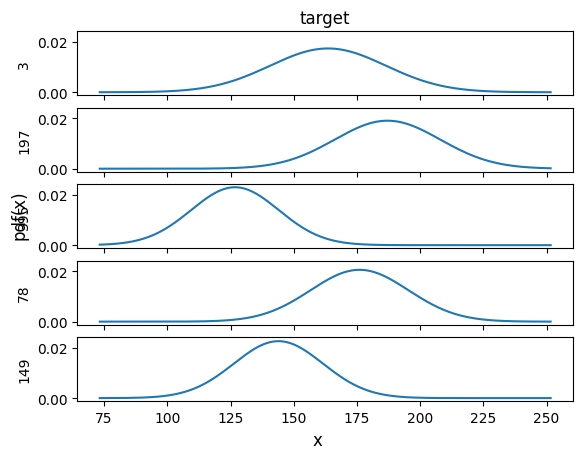

In [3]:
y_pred_proba = reg_proba.predict_proba(X_new)
y_pred_proba.head().plot()

`skpro` distribution objects are pandas-like

In [4]:
y_pred_proba.shape

(111, 1)

In [5]:
y_pred_proba.index  # same index as X_new

Index([  3, 197, 395,  78, 149, 105, 323,   9, 363, 369,
       ...
       346, 153, 178, 283,  34, 393, 316, 383, 122,  82],
      dtype='int64', length=111)

In [6]:
y_pred_proba.columns  # same columns as X_new

Index(['target'], dtype='object')

distribution objects have `sample` and methods such as `mean`, `var`:

In [7]:
y_pred_proba.sample().head()

,target
3,181.254107
197,199.392975
395,147.874808
78,165.939361
149,154.024654


In [8]:
y_pred_proba.mean().head()

,target
3,163.56
197,187.08
395,126.75
78,176.01
149,143.94


In [9]:
y_pred_proba.var().head()

,target
3,524.491525
197,436.051498
395,299.445215
78,374.212877
149,310.055919


more details on `skpro` distributions in the "distributions" tutorial!

### 1.1.2 interval predictions

interval prediction `y_pred_interval` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, nominal coverage, and bottom/upper bound

"we predict that value in row falls between bottom/upper with 90% chance"

In [10]:
y_pred_interval = reg_proba.predict_interval(X_new, coverage=0.9)
y_pred_interval.head()

target            
            0.9            
          lower       upper
3    125.889924  201.230076
197  152.732420  221.427580
395   98.286654  155.213346
78   144.190993  207.829007
149  114.976752  172.903248

multiple coverages can be passed:

In [11]:
coverage = [0.5, 0.9, 0.95]
y_pred_ints = reg_proba.predict_interval(X_new, coverage=coverage)
y_pred_ints

target                                                            
           0.50                    0.90                    0.95            
          lower       upper       lower       upper       lower       upper
3    148.112984  179.007016  125.889924  201.230076  118.673336  208.446664
197  172.995409  201.164591  152.732420  221.427580  146.152334  228.007666
395  115.078302  138.421698   98.286654  155.213346   92.833832  160.666168
78   162.962277  189.057723  144.190993  207.829007  138.095315  213.924685
149  132.063311  155.816689  114.976752  172.903248  109.428161  178.451839
..          ...         ...         ...         ...         ...         ...
393   94.468654  120.131346   76.008663  138.591337   70.014072  144.585928
316  216.443691  238.596309  200.508608  254.531392  195.333942  259.706058
383   94.264854  116.395146   78.345830  132.314170   73.176378  137.483622
122  261.935566  288.344434  242.938827  307.341173  236.769935  313.510065
82    75.425129   88.414871   66.081193   97.758807   63.046898  100.793102

[111 rows x 6 columns]

`predict_interval` output spec:

`pandas.DataFrame`\
Row index is as for `X_new`\
Column has multi-index:\
1st level = variable names from `y` in fit\
2nd level = coverage fractions in `coverage`\
3rd level = string `"lower"` or `"upper"`

Entries = interval prediction of lower/upper interval at nominal coverage in 2nd lvl, for var in 1st lvl, for data index in row

### 1.1.3 quantile predictions

quantile prediction `y_pred_quantiles` is a `pd.DataFrame`:

* rows are the same as `X_new`
* columns indicate variables, quantile points

"we predict the 5%, 50%, 95% quantile points for the row to be here"

In [12]:
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=[0.05, 0.5, 0.95])
y_pred_quantiles.head()

target                    
           0.05    0.50        0.95
3    125.889924  163.56  201.230076
197  152.732420  187.08  221.427580
395   98.286654  126.75  155.213346
78   144.190993  176.01  207.829007
149  114.976752  143.94  172.903248

multiple quantiles:

In [13]:
alpha = [0.1, 0.25, 0.5, 0.75, 0.9]
y_pred_quantiles = reg_proba.predict_quantiles(X_new, alpha=alpha)
y_pred_quantiles

target                                            
           0.10        0.25    0.50        0.75        0.90
3    134.210188  148.112984  163.56  179.007016  192.909812
197  160.318837  172.995409  187.08  201.164591  213.841163
395  104.573410  115.078302  126.75  138.421698  148.926590
78   151.218920  162.962277  176.01  189.057723  200.801080
149  121.373921  132.063311  143.94  155.816689  166.506079
..          ...         ...     ...         ...         ...
393   82.920042   94.468654  107.30  120.131346  131.679958
316  206.474668  216.443691  227.52  238.596309  248.565332
383   84.305877   94.264854  105.33  116.395146  126.354123
122  250.051163  261.935566  275.14  288.344434  300.228837
82    69.579542   75.425129   81.92   88.414871   94.260458

[111 rows x 5 columns]

`predict_quantiles` output spec:

`pandas.DataFrame`\
Row index is same as `X_new`\
Column has multi-index:\
1st level = variable names from `y` in `fit`\
2nd level = quantile points in `alpha`

Entries = quantiles prediction at quantile point in 2nd lvl, for var in 1st lvl, for data index in row

### 1.1.4 mean and variance predictions

mean and variance predictions `y_pred_mean`, `y_pred_var` are `pd.DataFrame`-s:

* rows are the same as `X_new`
* columns are the same as `X_new`

entries are predictive mean and variance in row/column

In [14]:
y_pred_mean = reg_proba.predict(X_new)
y_pred_var = reg_proba.predict_var(X_new)

In [15]:
y_pred_mean.head()

3      163.56
197    187.08
395    126.75
78     176.01
149    143.94
dtype: float64

In [16]:
y_pred_var.head()

,target
3,524.491525
197,436.051498
395,299.445215
78,374.212877
149,310.055919


this is the same as taking the distribution prediction and taking mean/variance

(for distribution objects that estimate these precisely)

In [17]:
y_pred_proba.mean().head()

,target
3,163.56
197,187.08
395,126.75
78,176.01
149,143.94


In [18]:
y_pred_proba.var().head()

,target
3,524.491525
197,436.051498
395,299.445215
78,374.212877
149,310.055919


## 1.2 simple evaluation workflow for probabilistic predictions

for simple evaluation:

1. split the data into train/test set
2. make predictions of either type for test features
3. compute metric on test set, comparing test predictions to hend out test labels

Note:

* metrics will compare tabular ground truth to probabilistic prediction
* the metric will needs to be of a compatible type, e.g., for proba predictions

In [19]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from skpro.metrics import CRPS
from skpro.regression.residual import ResidualDouble

# step 1: data specification
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# step 2: specifying the regressor
# example - linear regression for mean prediction
# random forest for variance prediction
reg_mean = LinearRegression()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

# step 3: fitting the model to training data
reg_proba.fit(X_train, y_train)

# step 4: predicting labels on new data
y_pred_proba = reg_proba.predict_proba(X_test)

# step 5: specifying evaluation metric
metric = CRPS()

# step 6: evaluate metric, compare predictions to actuals
metric(y_test, y_pred_proba)

27.880267965820437

how do we know that metric is of right type? Via `scitype:y_pred` tag

In [20]:
metric.get_tags()
# scitype:y_pred is pred_proba - for proba predictions

{'estimator_type': 'estimator',
 'authors': 'skpro developers',
 'maintainers': 'skpro developers',
 'object_type': ['metric', 'metric_distr'],
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': True}

how do we find metrics for a prediction type?

In [21]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
1,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...,pred_proba
2,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
3,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
4,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...,pred_proba
5,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
6,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
7,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>,pred_proba
8,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>,pred_proba


extra note: quantile metrics can be applied to interval predictions as well

more details on metrics below

## 1.3 diagnostic visualisations

some useful diagnostic visualisations: variants of crossplots for probabilistic predictions

A. crossplot ground truth vs prediction intervals.

Works with both proba and interval predictions.

What to look for: intervals shouhld cut through the x = y line (green points)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

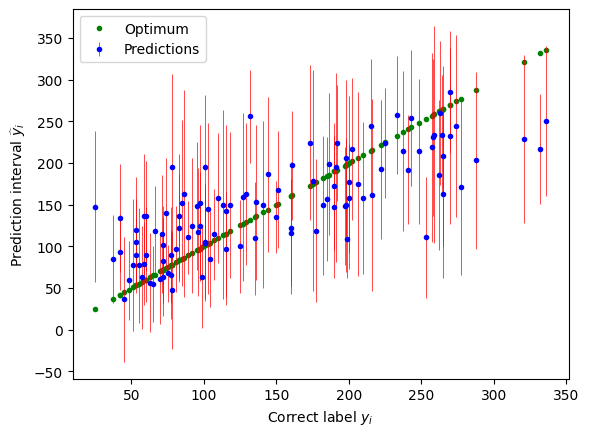

In [22]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

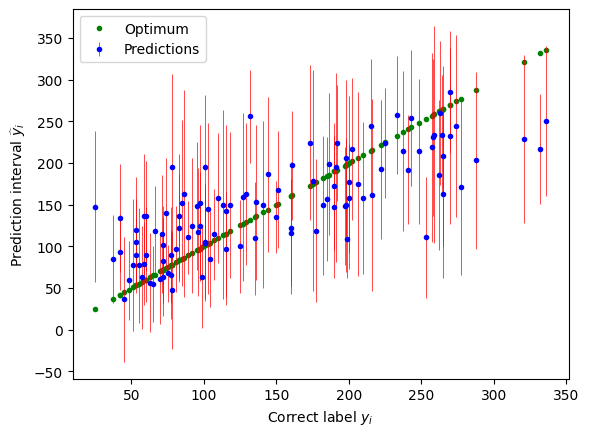

In [23]:
from skpro.utils.plotting import plot_crossplot_interval

y_pred_interval = reg_proba.predict_interval(X_test, coverage=0.9)
plot_crossplot_interval(y_test, y_pred_interval)

B. crossplot residuals vs predictive standard deviation

Works with both proba and variance predictions.

What to look for: should be close to a line, high linear correlation

<Axes: xlabel='Absolute errors $|y_i - \\widehat{y}_i|$', ylabel='Predictive standard deviation of $\\widehat{y}_i$'>

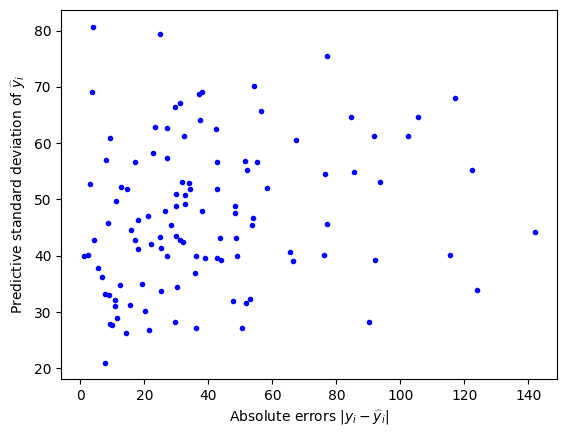

In [24]:
from skpro.utils.plotting import plot_crossplot_std

plot_crossplot_std(y_test, y_pred_proba)

<Axes: xlabel='Absolute errors $|y_i - \\widehat{y}_i|$', ylabel='Predictive standard deviation of $\\widehat{y}_i$'>

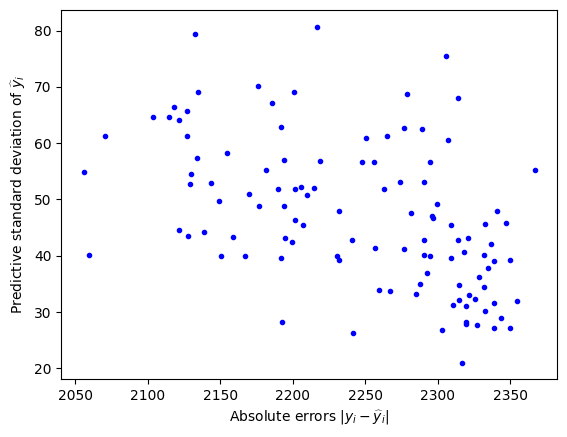

In [25]:
from skpro.utils.plotting import plot_crossplot_std

y_pred_var = reg_proba.predict_var(X_test)
plot_crossplot_std(y_test, y_pred_var)

C. crossplot ground truth vs loss values

Loss and prediction type should agree.

What to look for: association between accuracy and ground truth value

Diagnostic of which values we can predict more accurately,

e.g., to inform modelling or identify unusual outliers

<Axes: title={'center': 'mean CRPS: 27.88 +/- 2.06 sterr of mean'}, xlabel='Correct label $y_i$', ylabel='CRPS($y_i$, $\\widehat{y}_i$)'>

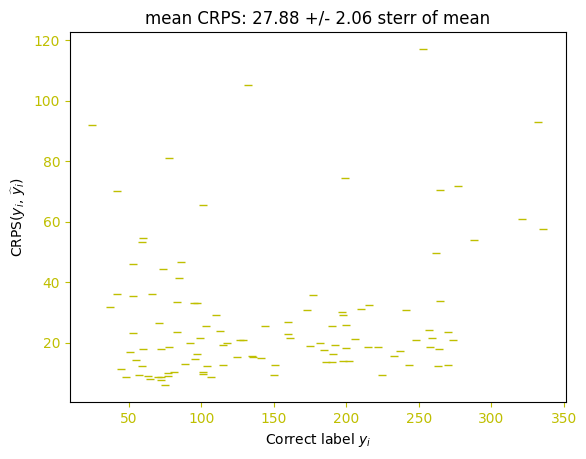

In [26]:
from skpro.utils.plotting import plot_crossplot_loss

crps_metric = CRPS()
plot_crossplot_loss(y_test, y_pred_proba, crps_metric)

### 1.4 `skpro` objects - `scikit-base` interface, searching for regressors and metrics

* `skpro` objects - `skbase` interface points `get_tags`, `get_params`/`set_params`
* searching estimators and metrics via `all_objects`

### 1.4.1 primer on `skpro` object interface <a class="anchor" id="section1_3_1"></a>

metrics and estimators are first-class citizens in `skpro`, with a `scikit-base` compatible interface

In [27]:
# example object 1: CRPS metric
from skpro.metrics import CRPS

crps_metric = CRPS()

# example object 2: ResidualDouble regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from skpro.regression.residual import ResidualDouble

reg_mean = LinearRegression()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, reg_resid)

e.g., all have `get_tags` interface

In [28]:
crps_metric.get_tags()

{'estimator_type': 'estimator',
 'authors': 'skpro developers',
 'maintainers': 'skpro developers',
 'object_type': ['metric', 'metric_distr'],
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': True}

In [29]:
reg_proba.get_tags()

{'estimator_type': 'regressor_proba',
 'authors': 'skpro developers',
 'maintainers': 'skpro developers',
 'object_type': 'regressor_proba',
 'capability:survival': False,
 'capability:multioutput': False,
 'capability:missing': True,
 'X_inner_mtype': 'pd_DataFrame_Table',
 'y_inner_mtype': 'pd_DataFrame_Table',
 'C_inner_mtype': 'pd_DataFrame_Table'}

the tag `object_type` indicates the type of object, e.g., metric or proba regressor

all objects also have the `get_params`/`set_params` interface known from `scikit-learn`

= reading or setting hyper-parameters

`get_params` returns `dict` `{paramname: paramvalue}`; `set_params` writes it

In [30]:
crps_metric.get_params()

{'multioutput': 'uniform_average', 'multivariate': False}

composite objects have the nested param interface, keys `componentname__paramname`

In [31]:
# note that reg_proba has components LinearRegression and RandomForestaregressor
# each with their own parameters
reg_proba

ResidualDouble(estimator=LinearRegression(),
               estimator_resid=RandomForestRegressor())

so `reg_proba` will have parameters coming from itself and either component:

In [32]:
reg_proba.get_params()

{'cv': None,
 'distr_loc_scale_name': None,
 'distr_params': None,
 'distr_type': 'Normal',
 'estimator': LinearRegression(),
 'estimator_resid': RandomForestRegressor(),
 'min_scale': 1e-10,
 'residual_trafo': 'absolute',
 'use_y_pred': False,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__n_jobs': None,
 'estimator__positive': False,
 'estimator_resid__bootstrap': True,
 'estimator_resid__ccp_alpha': 0.0,
 'estimator_resid__criterion': 'squared_error',
 'estimator_resid__max_depth': None,
 'estimator_resid__max_features': 1.0,
 'estimator_resid__max_leaf_nodes': None,
 'estimator_resid__max_samples': None,
 'estimator_resid__min_impurity_decrease': 0.0,
 'estimator_resid__min_samples_leaf': 1,
 'estimator_resid__min_samples_split': 2,
 'estimator_resid__min_weight_fraction_leaf': 0.0,
 'estimator_resid__n_estimators': 100,
 'estimator_resid__n_jobs': None,
 'estimator_resid__oob_score': False,
 'estimator_resid__random_state': None,
 'estimator_resid__ver

further common interface points are `get_config`, `set_config`, and `get_fitted_params` (only fittable estimators)

### 1.4.2 searching for regressors and metrics <a class="anchor" id="section1_3_2"></a>

as first-class citizens, all objects in `skpro` are indexed via the `registry` utility `all_objects`.

To find probabilistic supervised regressors, use `all_objects` with the type `regressor_proba`:

In [33]:
from skpro.registry import all_objects

all_objects("regressor_proba", as_dataframe=True).head()

,name,object
0,AFTFisk,<class 'skpro.survival.aft._aft_lifelines_fisk...
1,AFTLogNormal,<class 'skpro.survival.aft._aft_lifelines_logn...
2,AFTWeibull,<class 'skpro.survival.aft._aft_lifelines_weib...
3,ARDRegression,<class 'skpro.regression.linear._sklearn.ARDRe...
4,AalenAdditive,<class 'skpro.survival.additive._aalen_lifelin...


a full list can also be found in the online API reference.

for metrics, as seen above:

In [34]:
from skpro.registry import all_objects

all_objects("metric", as_dataframe=True, return_tags="scitype:y_pred")

,name,object,scitype:y_pred
0,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
1,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...,pred_proba
2,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
3,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
4,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...,pred_proba
5,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
6,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
7,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>,pred_proba
8,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>,pred_proba


all tags can be printed by the `all_tags` utility:

In [35]:
# all tags applicable to metrics
from skpro.registry import all_tags

all_tags("metric", as_dataframe=True)

,name,scitype,type,description
0,capability:survival,metric,bool,"whether metric uses censoring information, for..."
1,lower_is_better,metric,bool,whether lower (True) or higher (False) is better
2,scitype:y_pred,metric,str,expected input type for y_pred in performance ...


In [36]:
# all tags applicable to probabilistic regressors
from skpro.registry import all_tags

all_tags("regressor_proba", as_dataframe=True)

,name,scitype,type,description
0,C_inner_mtype,regressor_proba,"(list, str)",which machine type(s) is the internal _fit/_pr...
1,X_inner_mtype,regressor_proba,"(list, str)",which machine type(s) is the internal _fit/_pr...
2,capability:missing,regressor_proba,bool,whether estimator supports missing values
3,capability:multioutput,regressor_proba,bool,whether estimator supports multioutput regression
4,capability:survival,regressor_proba,bool,whether estimator can use censoring informatio...
5,y_inner_mtype,regressor_proba,"(list, str)",which machine type(s) is the internal _fit/_pr...


filtering in search can be done with the `filter_tags` argument in `all_objects`, see docstring:

In [37]:
from skpro.registry import all_objects

# "retrieve all genuinely probabilistic loss functions"
all_objects("metric", as_dataframe=True, filter_tags={"scitype:y_pred": "pred_proba"})

,name,object
0,CRPS,<class 'skpro.metrics._classes.CRPS'>
1,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...
2,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...
3,LogLoss,<class 'skpro.metrics._classes.LogLoss'>
4,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>
5,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>


## 2. Prediction types, metrics, benchmarking <a class="anchor" id="chapter2"></a>

This section gives more details on:

* different prediction types, including a methodological primer
* the API of metrics to compare probabilistic predictions to non-probabilistic actuals
* utilities for batch benchmarking of estimators and metrics

### 2.1 Probabilistic predictions - methodological primer <a class="anchor" id="section2_1"></a>

**readers familir with, or less interested in theory, may like to skip section 2.1**

In supervised learning - probabilistic or not:

* we fit estimator to i.i.d samples $(X_1, Y_1), \dots, (X_N, Y_N) \sim (X_*, Y_*)$
* and want to predict $y$ given $x$ accurately, for $(x, y) \sim (X_*, Y_*)$

Let $y$ be the (true) value, for an observed feature $x$

(we consider $y$ a random variable)

| Name | param | prediction/estimate of | `skpro` |
| ---- | ----- | ---------------------- | -------- |
| point prediction | | conditional expectation $\mathbb{E}[y\|x]$ | `predict` |
| variance prediction | | conditional variance $Var[y\|x]$ | `predict_var` |
| quantile prediction | $\alpha\in (0,1)$ | $\alpha$-quantile of $y\|x$ | `predict_quantiles` |
| interval prediction | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y \le b\| x) = c$ | `predict_interval` |
| distribution prediction | | the law/distribution of $y\|x$ | `predict_proba` |

##### More formal details & intuition:

let's consider the toy example again

In [38]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)

In [39]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from skpro.regression.residual import ResidualDouble

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_new, y_train, _ = train_test_split(X, y)


reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean)

reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_new)

* a **"point prediction"** is a prediction/estimate of the conditional expectation $\mathbb{E}[y|x]$.\
 **Intuition**: "out of many repetitions/worlds, this value is the arithmetic average of all observations".

In [40]:
# if y_pred_proba were *true*, here's how many repetitions would look like:

# repeating this line is "one repetition"
y_pred_proba.sample().head()

,target
102,138.470645
241,129.681224
282,133.812624
432,260.395023
33,73.546588


In [41]:
many_samples = y_pred_proba.sample(100)
many_samples

target
0  102  146.649904
   241  141.674200
   282  124.885507
   432  226.703394
   33   104.064224
...            ...
99 220   38.277940
   330  201.071314
   213   96.107157
   6     42.479152
   115  215.560492

[11100 rows x 1 columns]

In [42]:
# "doing many times and taking the mean" -> usual point prediction
mean_prediction = many_samples.groupby(level=1, sort=False).mean()
mean_prediction.head()

,target
102,149.718055
241,110.814113
282,132.969532
432,230.375040
33,100.993639


In [43]:
# if we would do this infinity times instead of 100:
y_pred_proba.mean().head()

,target
102,150.29
241,113.42
282,132.04
432,231.15
33,102.79


* a **"variance prediction"** is a prediction/estimate of the conditional expectation $Var[y|x]$.\
 **Intuition:** "out of many repetitions/worlds, this value is the average squared distance of the observation to the perfect point prediction".


In [44]:
# same as above - take many samples, and then compute element-wise statistics
var_prediction = many_samples.groupby(level=1, sort=False).var()
var_prediction.head()

,target
102,326.063122
241,272.877878
282,288.577677
432,280.419597
33,278.622982


In [45]:
# e.g., predict_var should give the same result as infinite large sample's variance
y_pred_proba.var().head()

,target
102,273.410721
241,273.410721
282,273.410721
432,273.410721
33,273.410721


* a **"quantile prediction"**, at quantile point $\alpha\in (0,1)$ is a prediction/estimate of the $\alpha$-quantile of $y'|y$, i.e., of $F^{-1}_{y|x}(\alpha)$, where $F^{-1}$ is the (generalized) inverse cdf = quantile function of the random variable y|x.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $\alpha$ will have equal or smaller than this value."
* an **"interval prediction"** or "predictive interval" with (symmetric) coverage $c\in (0,1)$ is a prediction/estimate pair of lower bound $a$ and upper bound $b$ such that $P(a\le y \le b| x) = c$ and $P(y \gneq b| x) = P(y \lneq a| x) = (1 - c) /2$.\
 **Intuition**: "out of many repetitions/worlds, a fraction of exactly $c$ will be contained in the interval $[a,b]$, and being above is equally likely as being below".

(similar - exercise left to the reader)

* a **"distribution prediction"** or "full probabilistic prediction" is a prediction/estimate of the distribution of $y|x$, e.g., "it's a normal distribution with mean 42 and variance 1".\
**Intuition**: exhaustive description of the generating mechanism of many repetitions/worlds.

note: the true distribution is unknown, and not accessible easily!

`y_pred_proba` is a distribution, but in general not equal to the true one!

that is, there are:

* *true* distribution `y_pred_proba_true` - unknown and unknowable but estimable
* `y_pred_proba` - our guess at `y_pred_proba_true`
* the actual data `y_true` is *one* `y_pred_proba_true.sample()`


* `predict` produces guess of `y_pred_proba_true.mean()`
* `predict_var` produces guess of `y_pred_proba_true.var()`
* `predict_quantiles([0.05, 0.5, 0.95])` produces guess of `y_pred_proba_true.quantiles([0.05, 0.5, 0.95])`
* `predict_proba` produces guess of `y_pred_proba_true`

the guesses are algorithm specific, and some algorithms are more accurate than others, given data

### 2.2 probabilistic metrics - details <a class="anchor" id="section2_2"></a>

General usage pattern same as for `sklearn` metrics:

1. get some actuals and predictions
2. specify the metric - similar to estimator specs
3. plug the actuals and predictions into metric to get metric values

*but*: need to use dedicated metric for probabilistic predictions

* ground truth: `y_true` samples
* prediction e.g., `y_predict_proba`, `y_predict_interval`
* so, match metric with type of prediction!
    * `metric(y_true: 2D pd.DataFrame, y_pred: proba_prediction_type) -> float`

Recall methods available for all probabilistic regressors:

- `predict_interval` produces interval predictions.
  Argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile predictions.
  Argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance predictions. Same args as `predict`.
- `predict_proba` produces full distributional predictions. Same args as `predict`.

| Name | param | prediction/estimate of | `skpro` |
| ---- | ----- | ---------------------- | -------- |
| point prediction | | conditional expectation $\mathbb{E}[y\|x]$ | `predict` |
| variance prediction | | conditional variance $Var[y\|x]$ | `predict_var` |
| quantile prediction | $\alpha\in (0,1)$ | $\alpha$-quantile of $y\|x$ | `predict_quantiles` |
| interval prediction | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y \le b\| x) = c$ | `predict_interval` |
| distribution prediction | | the law/distribution of $y\|x$ | `predict_proba` |

let's produce some probabilistic predictions!

In [46]:
# 1. get some actuals and predictions
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
# actuals = y_test

In [47]:
from sklearn.ensemble import RandomForestRegressor

from skpro.regression.residual import ResidualDouble

reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean)

reg_proba.fit(X_train, y_train)

# use any of the probabilistic methods, we have seen this
y_pred_int = reg_proba.predict_interval(X_test, coverage=0.95)
y_pred_q = reg_proba.predict_quantiles(X_test, alpha=[0.05, 0.95])
y_pred_proba = reg_proba.predict_proba(X_test)

recall, all have their own output format:

In [48]:
y_pred_int  # lower/upper intervals

target            
           0.95            
          lower       upper
175   65.377963  132.482037
93    38.007963  105.112037
170   41.137963  108.242037
105   76.017963  143.122037
7     76.837963  143.942037
..          ...         ...
49   135.807963  202.912037
414  151.257963  218.362037
269   64.367963  131.472037
279   64.107963  131.212037
232  124.657963  191.762037

[111 rows x 2 columns]

In [49]:
y_pred_q  # quantiles

target            
           0.05        0.95
175   70.772243  127.087757
93    43.402243   99.717757
170   46.532243  102.847757
105   81.412243  137.727757
7     82.232243  138.547757
..          ...         ...
49   141.202243  197.517757
414  156.652243  212.967757
269   69.762243  126.077757
279   69.502243  125.817757
232  130.052243  186.367757

[111 rows x 2 columns]

In [50]:
y_pred_proba  # sktime/skpro BaseDistribution

Normal(columns=Index(['target'], dtype='object'),
       index=Index([175,  93, 170, 105,   7, 264, 133, 237, 274, 370,
       ...
       173, 253,  53, 212, 392,  49, 414, 269, 279, 232],
      dtype='int64', length=111),
       mu=array([[ 98.93],
       [ 71.56],
       [ 74.69],
       [109.57],
       [110.39],
       [141.99],
       [ 83.61],
       [ 79.87],
       [144.44],
       [ 75.95],
       [180.99],
       [ 97.24],
       [153.78],
       [ 93.94],
       [126.26],
       [149.51],
       [233.92],
       [113.2 ],
       [181.91],
       [111.28],
       [24...
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091],
       [17.11870091]]))

we now need to apply a suitable metric, `metric(y_test, y_pred)`

IMPORTANT: sequence matters, `y_test` first; `y_pred` has very different type!

In [51]:
# 2. specify metric
# CRPS = continuous ranked probability score, for distribution predictions
from skpro.metrics import CRPS

crps = CRPS()

# 3. evaluate metric
crps(y_test, y_pred_proba)

38.547321051730464

how do we find a metric that fits the prediction type?

answer: metrics are tagged

important tag: `scitype:y_pred`

* `"pred_proba"` - distributional, can applied to distributions, `predict_proba` output
* `"pred_quantiles"` - quantile forecast metric, can be applied to quantile predictions, interval predictions, distributional predictions
    * applicable to `predict_quantiles`, `predict_interval`, `predict_proba` outputs
* `"pred_interval"` - interval forecast metric, can be applied to interval predictions, distributional predictions
    * applicable to `predict_interval`, `predict_proba` outputs

In [52]:
crps.get_tags()

{'estimator_type': 'estimator',
 'authors': 'skpro developers',
 'maintainers': 'skpro developers',
 'object_type': ['metric', 'metric_distr'],
 'reserved_params': ['multioutput', 'score_average'],
 'scitype:y_pred': 'pred_proba',
 'lower_is_better': True}

listing metrics with the tag, filtering for probabilistic tags:

(let's try to find a quantile prediction metric!)

In [53]:
from skpro.registry import all_objects

all_objects(
    "metric",
    as_dataframe=True,
    return_tags="scitype:y_pred",
)

,name,object,scitype:y_pred
0,CRPS,<class 'skpro.metrics._classes.CRPS'>,pred_proba
1,ConcordanceHarrell,<class 'skpro.metrics.survival._c_harrell.Conc...,pred_proba
2,ConstraintViolation,<class 'skpro.metrics._classes.ConstraintViola...,pred_interval
3,EmpiricalCoverage,<class 'skpro.metrics._classes.EmpiricalCovera...,pred_interval
4,LinearizedLogLoss,<class 'skpro.metrics._classes.LinearizedLogLo...,pred_proba
5,LogLoss,<class 'skpro.metrics._classes.LogLoss'>,pred_proba
6,PinballLoss,<class 'skpro.metrics._classes.PinballLoss'>,pred_quantiles
7,SPLL,<class 'skpro.metrics.survival._spll.SPLL'>,pred_proba
8,SquaredDistrLoss,<class 'skpro.metrics._classes.SquaredDistrLoss'>,pred_proba


`PinballLoss` is a quantile forecast metric:

In [54]:
from skpro.metrics import PinballLoss

pinball_loss = PinballLoss()

pinball_loss(y_test, y_pred_q)

13.124000434829115

... this is by default an average (grand average, float)

* averages over samples in `y_pred` / `y_test` (rows)
* averages over variables (columns)
* average over `alpha` values, quantile points

what if we don't want these averages?

* variable (column) averaging is controlled by the `multioutput` arg.
    * `"raw_values"` prevents averaging, `"uniform_average"` computes arithmetic mean.
* quantile points (`alpha`) or coverage (`coverage`) is controlled by `score_average` arg
* evaluation by row via the `evaluate_by_index` method
    * can be useful for diagnostics or statistical tests

In [55]:
# Example 1: Pinball loss by quantile point
loss_multi = PinballLoss(score_average=False)
loss_multi(y_test, y_pred_q)

0.05    10.994424
0.95    15.253577
Name: 0, dtype: float64

In [56]:
# Example 2: CRPS by test sample index
crps.evaluate_by_index(y_test, y_pred_proba)

,target
175,19.135950
93,15.962640
170,18.795242
105,46.916090
7,37.760777
...,...
49,18.500837
414,44.159622
269,6.688994
279,92.681807


Caveat: not every metric is an average over time points, e.g., RMSE

In this case, `evaluate_by_index` computes jackknife pseudo-samples

(for mean statistics, jackknife pseudo-samples are equal to individual samples)

### 2.3 Benchmark evaluation of probabilistic regressors <a class="anchor" id="section2_3"></a>

for quick evaluation and benchmarking,

the `benchmarking.evaluate` utility can be used:

In [57]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from skpro.benchmarking.evaluate import evaluate
from skpro.metrics import CRPS
from skpro.regression.residual import ResidualDouble

# 1. specify dataset
X, y = load_diabetes(return_X_y=True, as_frame=True)

# 2. specify estimator
estimator = ResidualDouble(LinearRegression())

# 3. specify cross-validation schema
cv = KFold(n_splits=3)

# 4. specify evaluation metric
crps = CRPS()

# 5. evaluate - run the benchmark
results = evaluate(estimator=estimator, X=X, y=y, cv=cv, scoring=crps)

# results are pd.DataFrame
# each row is one repetition of the cross-validation on one fold fit/predict/evaluate
# columns report performance, runtime, and other optional information (see docstring)
results

,test_CRPS,fit_time,pred_proba_time,len_y_train
0,31.783451,0.005134,0.002294,294
1,33.574329,0.005496,0.002145,295
2,29.909655,0.004958,0.002201,295


## 3. Advanced composition patterns <a class="anchor" id="chapter3"></a>

we introduce a number of composition patterns available in `skpro`:

* reducer-wrappers that turn `sklearn` regressors into probabilistic ones
* pipelines of `sklearn` transformers with `skpro` regressors
* tuning `skpro` probabilistic regressors via grid/random search, minimizing a probabilistic metric
* ensembling multiple `skpro` probabilistic regressors

data used in this section:

In [58]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

evaluation metric used in this section:

In [59]:
crps = CRPS()

### 3.1 Reducers to turn `sklearn` regressors probabilistic <a class="anchor" id="section3_1"></a>

there are many common algorithms that turn a non-probabilistic tabular regressor probabilistic

formally, this is a type of "reduction" - of probabilistic supervised tabular to non-probabilistic supervised tabular

Examples:

* predicting variance equal to training residual variance - `ResidualDouble` with standard settings
    * or other unconditional distribution estimate for residuals
* "squaring the residual" two-step prediction - `ResidualDouble`
* boostrap prediction intervals - `BootstrapRegressor`
* conformal prediction intervals - contributions appreciated :-)
* natural gradient boosting aka NGBoost - contributions appreciated :-)

### 3.1.1 constant variance prediction <a class="anchor" id="section3_1_1"></a>

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV
# note - in-sample predictions will usually underestimate the variance!

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

30.508913426677797

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

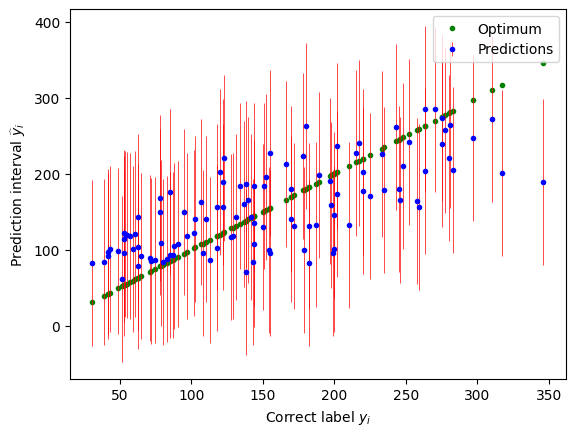

In [61]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.2 two-step residual prediction <a class="anchor" id="section3_1_2"></a>

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# estimator specification - use any sklearn regressor for reg_mean and reg_resid
reg_mean = RandomForestRegressor()
reg_resid = RandomForestRegressor()
reg_proba = ResidualDouble(reg_mean, estimator_resid=reg_resid, cv=KFold(5))
# cv is used to estimate out-of-sample residual variance via 5-fold CV

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

30.22836313909981

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

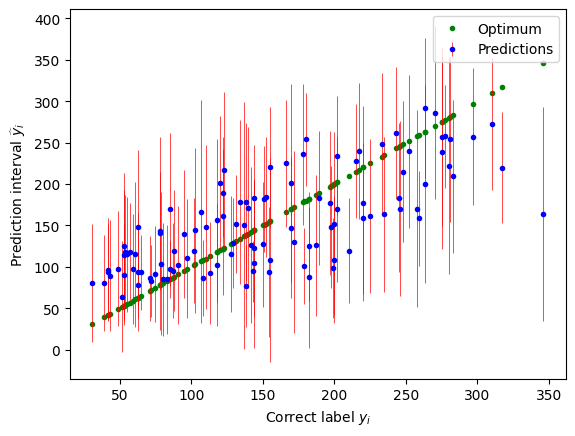

In [63]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.1.3 bootstrap prediction intervals <a class="anchor" id="section3_1_3"></a>

In [64]:
from sklearn.linear_model import LinearRegression

from skpro.regression.bootstrap import BootstrapRegressor

# estimator specification - use any sklearn regressor for reg_mean
reg_mean = LinearRegression()
reg_proba = BootstrapRegressor(reg_mean, n_bootstrap_samples=100)

# fit and predict
reg_proba.fit(X_train, y_train)
y_pred_proba = reg_proba.predict_proba(X_test)

# evaluate
crps(y_test, y_pred_proba)

35.5936968853179

<Axes: xlabel='Correct label $y_i$', ylabel='Prediction interval $\\widehat{y}_i$'>

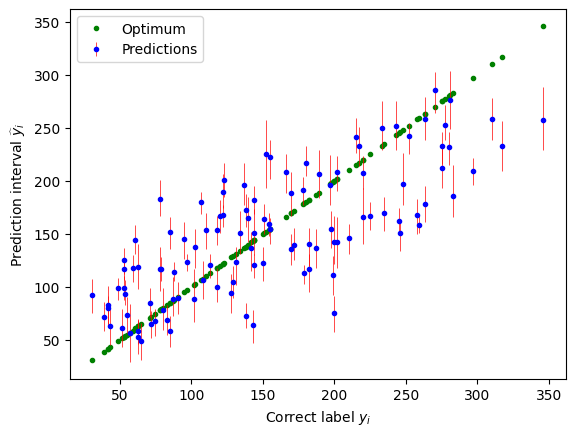

In [65]:
from skpro.utils.plotting import plot_crossplot_interval

plot_crossplot_interval(y_test, y_pred_proba, coverage=0.9)

### 3.2 Pipelines of `skpro` regressor and `sklearn` transformers <a class="anchor" id="section3_2"></a>

`skpro` regressors can be pipelined with `sklearn` transformers, using the `skpro` pipeline.

This ensure presence of `predict_proba` etc in the pipeline object.

The syntax is exactly the same as for `sklearn`'s pipeline.

In [66]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [67]:
from sklearn.impute import SimpleImputer as Imputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from skpro.regression.compose import Pipeline
from skpro.regression.residual import ResidualDouble

# estimator specification
reg_mean = LinearRegression()
reg_proba = ResidualDouble(reg_mean)

# pipeline is specified as a list of tuples (name, estimator)
pipe = Pipeline(
    steps=[
        ("imputer", Imputer()),  # an sklearn transformer
        ("scaler", MinMaxScaler()),  # an sklearn transformer
        ("regressor", reg_proba),  # an skpro regressor
    ]
)

In [68]:
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('regressor', ResidualDouble(estimator=LinearRegression()))])

In [69]:
# the pipeline behaves as any skpro regressor
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X=X_test)
y_pred_proba = pipe.predict_proba(X=X_test)

the pipeline provides the familiar nested `get_params`, `set_params` interface:

nested parameters are keyed `componentname__parametername`

In [70]:
pipe.get_params()

{'steps': [('imputer', SimpleImputer()),
  ('scaler', MinMaxScaler()),
  ('regressor', ResidualDouble(estimator=LinearRegression()))],
 'imputer': SimpleImputer(),
 'scaler': MinMaxScaler(),
 'regressor': ResidualDouble(estimator=LinearRegression()),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__keep_empty_features': False,
 'imputer__missing_values': nan,
 'imputer__strategy': 'mean',
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'regressor__cv': None,
 'regressor__distr_loc_scale_name': None,
 'regressor__distr_params': None,
 'regressor__distr_type': 'Normal',
 'regressor__estimator': LinearRegression(),
 'regressor__estimator_resid': None,
 'regressor__min_scale': 1e-10,
 'regressor__residual_trafo': 'absolute',
 'regressor__use_y_pred': False,
 'regressor__estimator__copy_X': True,
 'regressor__estimator__fit_intercept': True,
 'regressor__estimator__n_jobs': None,
 'regressor__estimator__posi

pipelines can also be created via simple lists of estimators,

in this case names are generated automatically:

In [71]:
# pipeline is specified as a list of tuples (name, estimator)
pipe = Pipeline(
    steps=[
        Imputer(),  # an sklearn transformer
        MinMaxScaler(),  # an sklearn transformer
        reg_proba,  # an skpro regressor
    ]
)

### 3.3 Tuning of `skpro` regressors via grid and random search <a class="anchor" id="section3_3"></a>

`skpro` provides grid and random search tuners to tune arbitrary probabilistic regressors,

using probabilistic metrics. Besides this, they function as the `sklearn` tuners do.

In [72]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

from skpro.metrics import CRPS
from skpro.model_selection import GridSearchCV
from skpro.regression.residual import ResidualDouble

# cross-validation specification for tuner
cv = KFold(n_splits=3)

# estimator to be tuned
estimator = ResidualDouble(LinearRegression())

# tuning grid - do we fit an intercept in the linear regression?
param_grid = {"estimator__fit_intercept": [True, False]}

# metric to be optimized
crps_metric = CRPS()

# specification of the grid search tuner
gscv = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=cv,
    scoring=crps_metric,
)

In [74]:
gscv

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=ResidualDouble(estimator=LinearRegression()),
             param_grid={'estimator__fit_intercept': [True, False]},
             scoring=CRPS())

the grid search tuner behaves like any `skpro` probabilistic regressor:

In [75]:
gscv.fit(X_train, y_train)
y_pred = gscv.predict(X_test)
y_pred_proba = gscv.predict_proba(X_test)

random search is similar, except that instead of a grid a parameter sampler should be specified:

In [76]:
from skpro.model_selection import RandomizedSearchCV

# only difference to GridSearchCV is the param_distributions argument

# specification of the random search parameter sampler
param_distributions = {"estimator__fit_intercept": [True, False]}

# specification of the random search tuner
rscv = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distributions,
    cv=cv,
    scoring=crps_metric,
)

### 3.4 Bagging/mixture ensemble of probabilistic regressors <a class="anchor" id="section3_3"></a>

Classical bagging does the following, for a wrapped estimator:

In `fit`:

1. subsample rows and/or columns of `X`, `y` to `X_subs`, `y_subs`
2. fit clone of wrapped estimator to `X_subs`, `y_subs`
3. Repeat 1-2 `n_estimators` times, store that many fitted clones.

In `predict`, for `X_test`:

1. for all fitted clones, obtain predictions on `X_test` - these are distributions
2. return the uniform mixture of these distributions, per test sample

In [77]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [78]:
from sklearn.linear_model import LinearRegression

from skpro.regression.ensemble import BaggingRegressor
from skpro.regression.residual import ResidualDouble

reg_mean = LinearRegression()
reg_proba = ResidualDouble(reg_mean)

ens = BaggingRegressor(reg_proba, n_estimators=10)
ens.fit(X_train, y_train)

y_pred = ens.predict_proba(X_test)

In [79]:
# y_pred is a mixture distribution!
str(y_pred)

"Mixture(columns=Index(['target'], dtype='object'),\n        distributions=[Normal(columns=Index(['target'], dtype='object'),\n                              index=Index([366, 311, 188, 263,  68,  96, 427, 235, 424, 236,\n       ...\n       132,  19, 173, 379, 227,  35, 401, 174,   5, 148],\n      dtype='int64', length=111),\n                              mu=array([[235.83179208],\n       [163.58317773],\n       [163.57602551],\n       [ 39.19668912],\n       [112.44346716],\n       [214.38067207],\n       [131.81838619],\n       [186.17...\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649],\n       [40.51030649]]))],\n        index=Index([366, 311, 188, 263,  68,  96, 427, 23

In [80]:
[type(x) for x in y_pred.distributions]

[skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal,
 skpro.distributions.normal.Normal]

## 4. Extension guide - implementing your own probabilistic regressor <a class="anchor" id="chapter4"></a>


`skpro` is meant to be easily extensible, for direct contribution to `skpro` as well as for local/private extension with custom methods.

To get started:

* Follow the ["implementing estimator" developer guide](https://skpro.readthedocs.io/en/stable/developer_guide/add_estimators.html)
* Use the [probabilistic regressor template](https://github.com/sktime/skpro/blob/main/extension_templates/regression.py) to get started

1. Read through the [probabilistic regression extension template](https://github.com/sktime/skpro/blob/main/extension_templates/regression.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. Copy the proba regressor extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `skpro` or affiliated repository (if contributed extension), inside `skpro.regression`; rename the file and update the file docstring appropriately.
3. Address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, and at least one of the probabilistic prediction methods, preferably `_predict_proba` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
4. To test your estimator manually: import your estimator and run it in the worfklows in Section 1; then use it in the compositors in Section 3.
5. To test your estimator automatically: call `skpro.utils.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `skpro` or one of its affiliated packages, additionally:

* Add yourself as an author to the code, and to the `CODEOWNERS` for the new estimator file(s).
* Create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* In the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* Before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 5. Summary<a class="anchor" id="chapter5"></a>

* `skpro` is a unified interface toolbox for probabilistic supervised regression, that is, for prediction intervals, quantiles, fully distributional predictions, in a tabular regression setting. The interface is fully interoperable with `scikit-learn` and `scikit-base` interface specifications.

* `skpro` comes with rich composition functionality that allows to build complex pipelines easily, and connect easily with other parts of the open source ecosystem, such as `scikit-learn` and individual algorithm libraries.

* `skpro` is easy to extend, and comes with user friendly tools to facilitate implementing and testing your own probabilistic regressors and composition principles.

---

### Credits:

noteook creation: fkiraly

skpro: https://github.com/sktime/skpro/blob/main/CONTRIBUTORS.md